# NYC Energy Star Rated Building Analysis

In [1]:
 from __future__ import print_function, division
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gp
import os
import json
%matplotlib  inline


import statsmodels.api as sm

In [2]:
nrg2013 = gp.GeoDataFrame.from_csv("DATA/2013 New York Benchmarking Ordinance (excl. audit data) (1).csv")
nrg2014 = gp.GeoDataFrame.from_csv("DATA/2014-Energy_and_Water_Data_Disclosure_for_Local_Law__2014.csv")
#nrg2014.head()

In [3]:
#Replace strings
nrg2013.columns = [c.replace(' ', '_') for c in nrg2013.columns]
nrg2014.columns = [c.replace(' ', '_') for c in nrg2014.columns]

In [4]:
nrg2013 = nrg2013[['BBL', 'ENERGY_STAR_Score', 'Weather_Normalized_Source_EUI_(kBtu/ft^2)', 'Reported_Floor_Area_(ft^2)']]
nrg2014 = nrg2014[['NYC_Borough,_Block,_and_Lot_(BBL)', 'ENERGY_STAR_Score', 'Weather_Normalized_Source_EUI(kBtu/ft2)', 
                   'Reported_Property_Floor_Area_(Building(s))_(ft²)']]

In [5]:
new_columns = ['bbl', 'energy_star', 'wns_eui', 'reported_sqft']

In [6]:
nrg2013.columns = new_columns
nrg2014.columns = new_columns

In [7]:
nrg2013['year'] = 2013
nrg2014['year'] = 2014

In [8]:
# strings to numeric
nrg2014 = nrg2014.apply(lambda x: pd.to_numeric(x, errors='coerce'))

In [9]:
nrg2013 = nrg2013.dropna()
nrg2014 = nrg2014.dropna()

In [ ]:
# add log values
nrg2013 = nrg2013.assign(log_wns_eui=np.log(nrg2013.wns_eui))
nrg2013 = nrg2013.assign(log_reported_sqft=np.log(nrg2013.reported_sqft))

nrg2014 = nrg2014.assign(log_wns_eui=np.log(nrg2014.wns_eui+0.01))
nrg2014 = nrg2014.assign(log_reported_sqft=np.log(nrg2014.reported_sqft+0.01))

In [ ]:
# REMOVE one outlier
nrg2014 = nrg2014.query("wns_eui<1e6")

In [12]:
nrg2013 = nrg2013.assign(energy_ge50=nrg2013.energy_star>=50)
nrg2014 = nrg2014.assign(energy_ge50=nrg2014.energy_star>=50)

nrg2013.energy_ge50 = nrg2013.energy_ge50.astype(int)
nrg2014.energy_ge50 = nrg2014.energy_ge50.astype(int)

In [13]:
# not using
nrg2013_lt50 = nrg2013.query("energy_star < 50")
nrg2013_ge50 = nrg2013.query("energy_star >= 50")

nrg2014_lt50 = nrg2014.query("energy_star < 50")
nrg2014_ge50 = nrg2014.query("energy_star >= 50")

# merging data

In [14]:
nrg = pd.concat([nrg2013, nrg2014])

# Merged Shape

In [15]:
print (nrg.shape)

(8485, 8)


In [16]:
print (nrg2013.shape, nrg2014.shape)

(1542, 8) (6943, 8)


In [17]:
nrg2013.head()

,bbl,energy_star,wns_eui,reported_sqft,year,log_wns_eui,log_reported_sqft,energy_ge50
Property Name,,,,,,,,
NaT,1.005050e+09,44.0,201.2,235370.0,2013,5.304299,12.368914,0
NaT,2.040830e+09,98.0,80.8,53275.0,2013,4.391977,10.883222,1
NaT,1.008070e+09,57.0,257.3,204417.0,2013,5.550243,12.227917,1
NaT,1.012090e+09,100.0,23.5,56442.0,2013,3.157000,10.940969,1
NaT,1.012920e+09,74.0,175.2,104990.0,2013,5.165928,11.561620,1


In [18]:
nrg2014.head()

,bbl,energy_star,wns_eui,reported_sqft,year,log_wns_eui,log_reported_sqft,energy_ge50
Record Number,,,,,,,,
2734969.0,1010950035,31.0,249.0,153363.0,2014,5.517493,11.940563,0
2741228.0,1021390017,20.0,419.0,256013.0,2014,6.037895,12.452984,0
3108893.0,1008020056,78.0,158.3,117291.0,2014,5.064555,11.672413,1
3893138.0,1006970031,39.0,186.4,215000.0,2014,5.227949,12.278393,0
4495647.0,1001727501,79.0,112.5,121689.0,2014,4.723042,11.709224,1


In [19]:
nrg2013.describe()

,bbl,energy_star,wns_eui,reported_sqft,year,log_wns_eui,log_reported_sqft,energy_ge50
count,1.542000e+03,1542.000000,1542.000000,1.542000e+03,1542.0,1542.000000,1542.000000,1542.000000
mean,1.856788e+09,60.537613,208.541829,2.765590e+05,2013.0,5.109950,11.973078,0.669261
std,1.256658e+09,28.648254,141.542622,3.919691e+05,0.0,0.782197,0.975723,0.470632
min,1.000048e+09,1.000000,1.100000,6.106000e+03,2013.0,0.095310,8.717027,0.000000
25%,1.008398e+09,41.000000,128.925000,7.433100e+04,2013.0,4.859231,11.216283,0.000000
50%,1.012900e+09,67.000000,190.350000,1.298055e+05,2013.0,5.248864,11.773792,1.000000
75%,3.011183e+09,83.000000,253.150000,2.932690e+05,2013.0,5.533982,12.588846,1.000000
max,5.074810e+09,100.000000,1651.400000,3.636683e+06,2013.0,7.409379,15.106583,1.000000


In [20]:
nrg2014.describe()

,bbl,energy_star,wns_eui,reported_sqft,year,log_wns_eui,log_reported_sqft,energy_ge50
count,6.943000e+03,6943.000000,6943.000000,6.943000e+03,6943.0,6943.000000,6943.000000,6943.000000
mean,2.190202e+09,55.245283,488.672130,1.842589e+05,2014.0,4.869592,11.665143,0.592251
std,1.208264e+09,29.999989,6092.819225,3.500912e+05,0.0,0.832100,1.008834,0.491451
min,1.000048e+09,0.000000,0.000000,0.000000e+00,2014.0,-4.605170,-4.605170,0.000000
25%,1.012924e+09,31.000000,104.200000,6.765250e+04,2014.0,4.646408,11.122140,0.000000
50%,2.030440e+09,59.000000,129.600000,9.643200e+04,2014.0,4.864530,11.476593,1.000000
75%,3.061290e+09,80.000000,168.100000,1.677730e+05,2014.0,5.124619,12.030367,1.000000
max,5.077020e+09,100.000000,304775.300000,1.421712e+07,2014.0,12.627330,16.469957,1.000000


In [21]:
nrg.describe()

,bbl,energy_star,wns_eui,reported_sqft,year,log_wns_eui,log_reported_sqft,energy_ge50
count,8.485000e+03,8485.000000,8485.000000,8.485000e+03,8485.000000,8485.000000,8485.000000,8485.000000
mean,2.129610e+09,56.207071,437.763359,2.010328e+05,2013.818268,4.913273,11.721105,0.606246
std,1.223900e+09,29.827156,5512.767622,3.598068e+05,0.385647,0.828413,1.009848,0.488610
min,1.000048e+09,0.000000,0.000000,0.000000e+00,2013.000000,-4.605170,-4.605170,0.000000
25%,1.012240e+09,32.000000,106.100000,6.844000e+04,2014.000000,4.664476,11.133713,0.000000
50%,2.026220e+09,60.000000,135.100000,1.007520e+05,2014.000000,4.906015,11.520417,1.000000
75%,3.056500e+09,81.000000,185.700000,1.844280e+05,2014.000000,5.224186,12.125014,1.000000
max,5.077020e+09,100.000000,304775.300000,1.421712e+07,2014.000000,12.627330,16.469957,1.000000


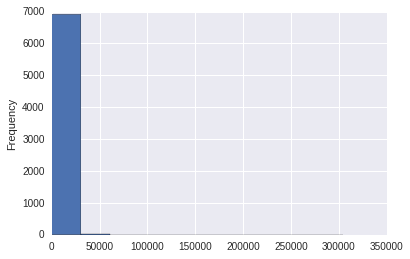

In [22]:
nrg2014['wns_eui'].plot(kind="hist")

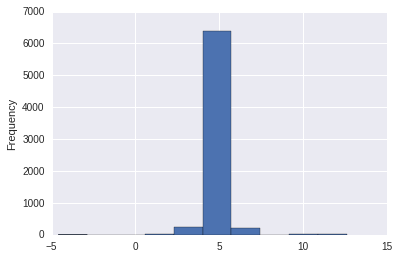

In [23]:
nrg2014['log_wns_eui'].plot(kind="hist")

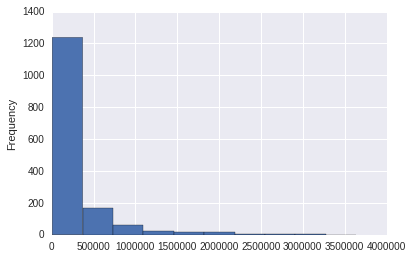

In [24]:
nrg2013['reported_sqft'].plot(kind="hist")

# Weather Normalized EUI (y) vs. Reported Floor area Sq. Ft (x)

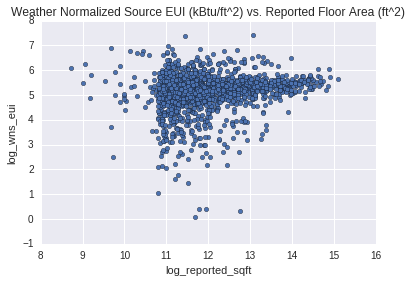

In [28]:
nrg2013.plot(x='log_reported_sqft', y='log_wns_eui', kind='scatter', title="Weather Normalized Source EUI (kBtu/ft^2) vs. Reported Floor Area (ft^2)")

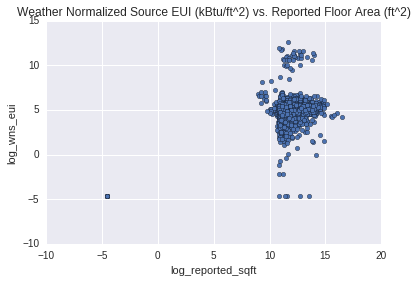

In [36]:
nrg2014.plot(x='log_reported_sqft', y='log_wns_eui', kind='scatter', title="Weather Normalized Source EUI (kBtu/ft^2) vs. Reported Floor Area (ft^2)")

# Weather Normalized EUI (y) vs. Reported Floor area Sq. Ft (x)
## Regression

In [38]:
# 2013
regression = sm.OLS(nrg2013['log_wns_eui'], nrg2013['log_reported_sqft']).fit()

In [54]:

regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            log_wns_eui   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                 1.556e+05
Date:                Thu, 15 Dec 2016   Prob (F-statistic):               0.00
Time:                        23:20:19   Log-Likelihood:                -7663.6
No. Observations:                6943   AIC:                         1.533e+04
Df Residuals:                    6941   BIC:                         1.534e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
log_reported_sqft     0.4450      0.001    379.845      0.000         0.443     0.447
energy_ge50          -0.5617      0.018    -31.510      0.000        -0.597    -0.527
==============================================================================
Omnibus:                     2253.663   Durbin-Watson:                   1.716
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           512084.067
Skew:                          -0.201   Prob(JB):                         0.00
Kurtosis:                      45.071   Cond. No.                         23.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
# 2014
regression = sm.OLS(nrg2014['log_wns_eui'], nrg2014['log_reported_sqft']).fit()

In [41]:
# R-2: 0.975
# T = 521.0, P<0.001
regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            log_wns_eui   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                 2.714e+05
Date:                Thu, 15 Dec 2016   Prob (F-statistic):               0.00
Time:                        22:55:43   Log-Likelihood:                -8127.7
No. Observations:                6943   AIC:                         1.626e+04
Df Residuals:                    6942   BIC:                         1.626e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
log_reported_sqft     0.4166      0.001    521.001      0.000         0.415     0.418
==============================================================================
Omnibus:                     2137.588   Durbin-Watson:                   1.715
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           413583.359
Skew:                           0.008   Prob(JB):                         0.00
Kurtosis:                      40.811   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# By Energy Star <50

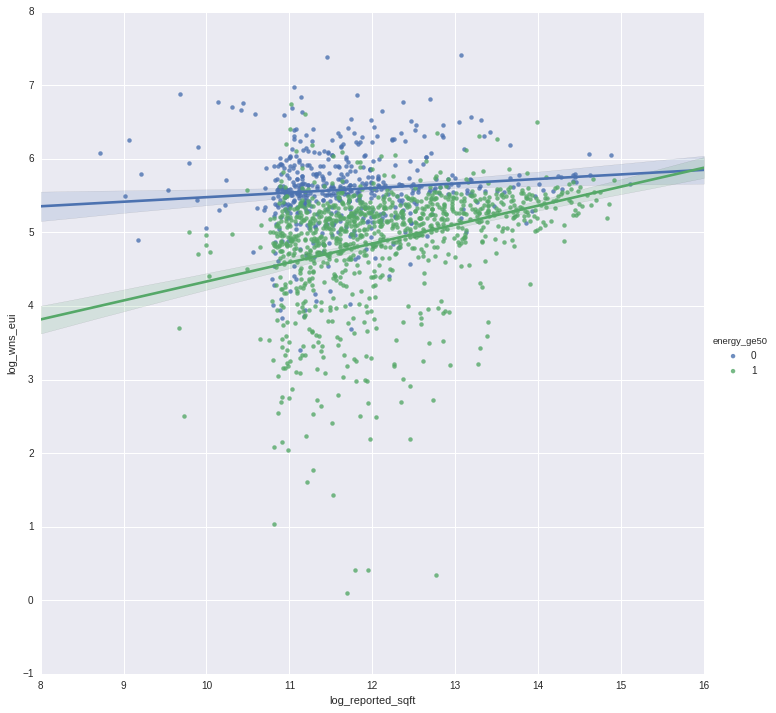

In [42]:
# 2013
sns_plot=sns.lmplot(x='log_reported_sqft',  y='log_wns_eui', data=nrg2013, hue="energy_ge50", size=10)

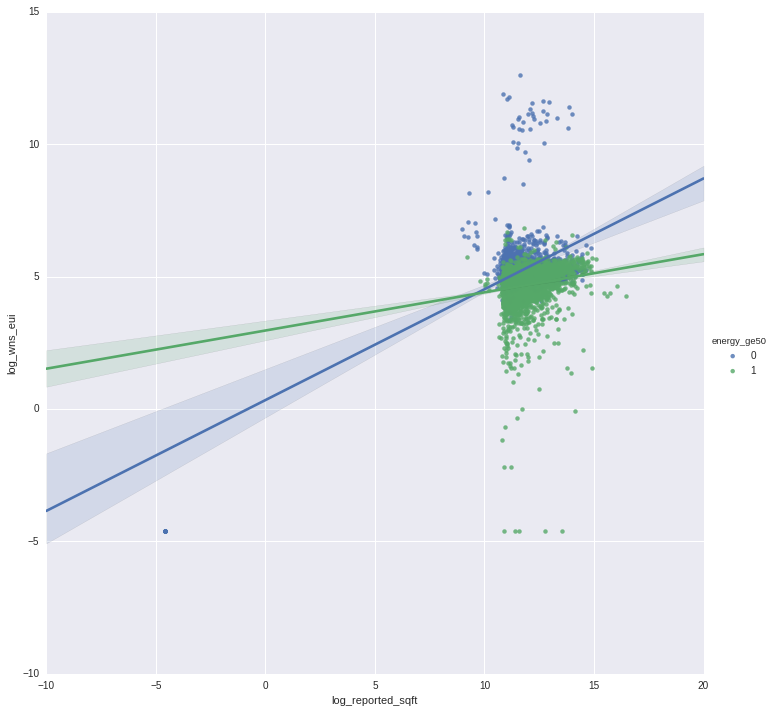

In [53]:
# 2014
sns_plot=sns.lmplot(x='log_reported_sqft',  y='log_wns_eui', data=nrg2014, hue="energy_ge50", size=10)


In [48]:
# 2013
y = nrg2013['log_wns_eui']
X = nrg2013[['log_reported_sqft', 'energy_ge50']]

regression = sm.OLS(y, X).fit()

In [49]:
regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            log_wns_eui   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                 3.777e+04
Date:                Thu, 15 Dec 2016   Prob (F-statistic):               0.00
Time:                        22:56:16   Log-Likelihood:                -1704.1
No. Observations:                1542   AIC:                             3412.
Df Residuals:                    1540   BIC:                             3423.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
log_reported_sqft     0.4716      0.003    172.205      0.000         0.466     0.477
energy_ge50          -0.8345      0.040    -20.750      0.000        -0.913    -0.756
==============================================================================
Omnibus:                      419.222   Durbin-Watson:                   1.683
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1933.127
Skew:                          -1.213   Prob(JB):                         0.00
Kurtosis:                       7.920   Cond. No.                         26.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [50]:
# 2014
y = nrg2014['log_wns_eui']
X = nrg2014[['log_reported_sqft', 'energy_ge50']]

regression = sm.OLS(y, X).fit()

In [56]:
regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            log_wns_eui   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                 1.556e+05
Date:                Thu, 15 Dec 2016   Prob (F-statistic):               0.00
Time:                        23:34:52   Log-Likelihood:                -7663.6
No. Observations:                6943   AIC:                         1.533e+04
Df Residuals:                    6941   BIC:                         1.534e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
log_reported_sqft     0.4450      0.001    379.845      0.000         0.443     0.447
energy_ge50          -0.5617      0.018    -31.510      0.000        -0.597    -0.527
==============================================================================
Omnibus:                     2253.663   Durbin-Watson:                   1.716
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           512084.067
Skew:                          -0.201   Prob(JB):                         0.00
Kurtosis:                      45.071   Cond. No.                         23.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""